## Import libraries

In [1]:
import torch
import torch.nn as nn
import keras
import cv2
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import pandas as pd

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Load Data

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [4]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

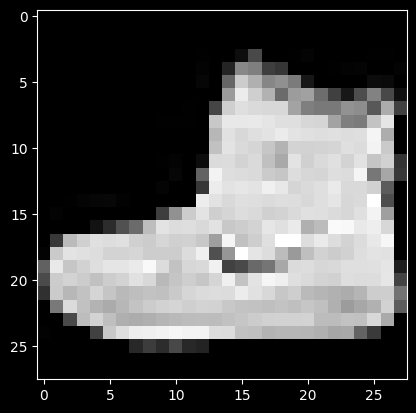

In [5]:
plt.imshow(X_train[0],cmap='gray')

In [6]:
X_train[0].shape

(28, 28)

## Reshape the (28,28) image to (64,64)

In [7]:
X_train_resized_images = []
X_test_resized_images = []

for i in range(len(X_train)):
  X_train_resized_images.append(cv2.resize(X_train[i], (64, 64)))
X_train_resized_images = np.array(X_train_resized_images)

for i in range(len(X_test)):
  X_test_resized_images.append(cv2.resize(X_test[i], (64, 64)))
X_test_resized_images = np.array(X_test_resized_images)

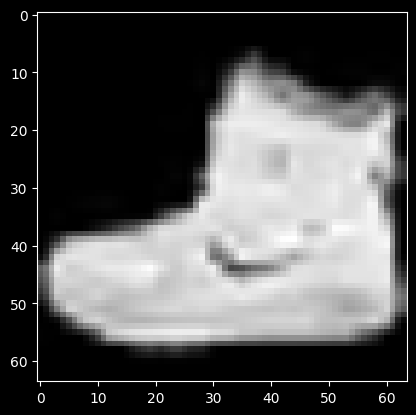

In [8]:
plt.imshow(X_train_resized_images[0],cmap='gray')

In [9]:
X_train_resized_images[0].shape

(64, 64)

In [10]:
class_labels = ["T-shirt/top","Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt","Sneaker","Bag","Ankle boot"]

## Normalise the intensity values

In [11]:
X_train_resized_images = X_train_resized_images/255.0
X_test_resized_images = X_test_resized_images/255.0

In [12]:
X_train_resized_images = X_train_resized_images.reshape(-1, 4096)
X_test_resized_images = X_test_resized_images.reshape(-1, 4096)

## Transform to Tensor and Using DataLoader

In [13]:
# Convert to tensor
train_data = torch.tensor(X_train_resized_images).float()
train_labels = torch.tensor(y_train).long()
test_data = torch.tensor(X_test_resized_images).float()
test_labels = torch.tensor(y_test).long()


# Convert to PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Place into dataloader
batchsize    = 64
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size = test_data.tensors[0].shape[0])

In [14]:
test_data.tensors[0].shape[0]

10000

## Observe the batches of training and test data

In [15]:
for X,y in train_loader:
    break
print(X.shape)
print(y.shape)

torch.Size([64, 4096])
torch.Size([64])


In [16]:
X,y = next(iter(test_loader))
print(X.shape)
print(y.shape)

torch.Size([10000, 4096])
torch.Size([10000])


## Training and Testing the model

In [17]:
def training_and_testing(model):
  epochs = 101
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=.001)

  model.to(device)

  losses    = torch.zeros(epochs)
  trainAcc  = []
  testAcc   = []


  for epoch in range(epochs):
    model.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
      X = X.to(device)
      y = y.to(device)

      ypred = model(X)
      loss = lossfun(ypred,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      ypred = ypred.cpu()
      y = y.cpu()


      acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
      batchAcc.append(acc)

    trainAcc.append( np.mean(batchAcc) )

    losses[epoch] = np.mean(batchLoss)

    # TESTING

    model.eval()
    X,y = next(iter(test_loader))

    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
      ypred = model(X)

      ypred = ypred.cpu()
      y = y.cpu()

      testAcc.append( 100*torch.mean((torch.argmax(ypred,dim=1)==y).float()) )
      if (epoch % 10) == 0:

            print(f' epochs : {epoch}  loss : {loss : 2.2f}')
  return losses, trainAcc, testAcc

In [18]:
def plot_fn(losses, trainAcc, testAcc):
  fig,ax = plt.subplots(1,2,figsize=(18,6))

  ax[0].plot(losses,'g', lw = 3)
  ax[0].set_xlabel('Epochs', fontsize = 15)
  ax[0].set_ylabel('Loss', fontsize = 15)
  ax[0].legend(['Train','Test'], fontsize = 15)
  ax[0].set_title('Training loss', fontsize = 25)

  ax[1].plot(trainAcc,label='Training Acc', lw =3)
  ax[1].plot(testAcc,label='Testing Acc', lw = 3)
  ax[1].set_xlabel('Epochs', fontsize = 15)
  ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
  ax[1].set_ylim([10,100])
  ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
  ax[1].legend(fontsize = 15)

  plt.show()

## Model - 1(without batch norm & drop out)

In [19]:
model1 = nn.Sequential(
          nn.Linear(4096,64),
          nn.ReLU(),
          nn.Linear(64,32),
          nn.ReLU(),
          nn.Linear(32,10),
          )
model1

Sequential(
  (0): Linear(in_features=4096, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=10, bias=True)
)

In [20]:
losses, trainAcc, testAcc = training_and_testing(model1)

 epochs : 0  loss :  0.42
 epochs : 10  loss :  0.29
 epochs : 20  loss :  0.30
 epochs : 30  loss :  0.15
 epochs : 40  loss :  0.14
 epochs : 50  loss :  0.24
 epochs : 60  loss :  0.14
 epochs : 70  loss :  0.12
 epochs : 80  loss :  0.18
 epochs : 90  loss :  0.09
 epochs : 100  loss :  0.07


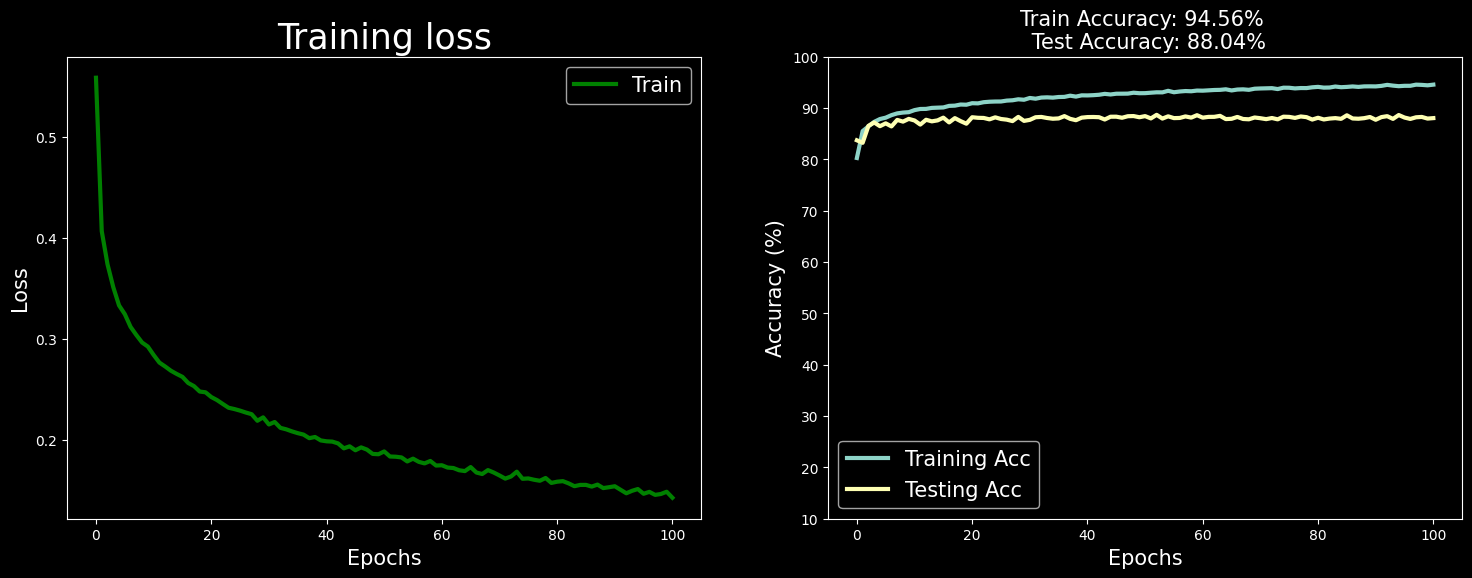

In [22]:
plot_fn(losses, trainAcc, testAcc)

## Model 2(with only batch norm)

In [23]:
model2 = nn.Sequential(
          nn.Linear(4096,64),
          nn.ReLU(),
          nn.BatchNorm1d(64),
          nn.Linear(64,32),
          nn.ReLU(),
          nn.BatchNorm1d(32),
          nn.Linear(32,10),
          )
model2

Sequential(
  (0): Linear(in_features=4096, out_features=64, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [24]:
losses, trainAcc, testAcc = training_and_testing(model2)

 epochs : 0  loss :  0.37
 epochs : 10  loss :  0.45
 epochs : 20  loss :  0.32
 epochs : 30  loss :  0.19
 epochs : 40  loss :  0.44
 epochs : 50  loss :  0.20
 epochs : 60  loss :  0.41
 epochs : 70  loss :  0.32
 epochs : 80  loss :  0.15
 epochs : 90  loss :  0.18
 epochs : 100  loss :  0.25


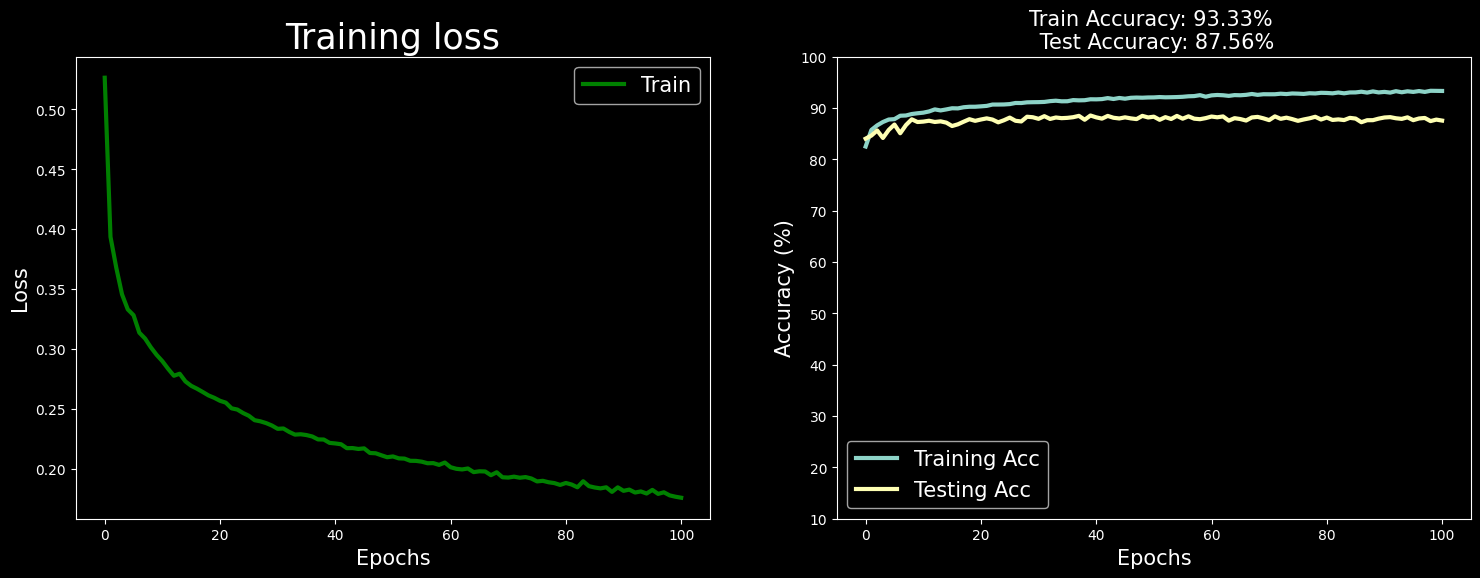

In [25]:
plot_fn(losses, trainAcc, testAcc)

## Model 3(with only drop out)

In [26]:
model3 = nn.Sequential(
          nn.Linear(4096,64),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(64,32),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(32,10),
          )
model3

Sequential(
  (0): Linear(in_features=4096, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [27]:
losses, trainAcc, testAcc = training_and_testing(model3)

 epochs : 0  loss :  0.70
 epochs : 10  loss :  0.44
 epochs : 20  loss :  0.39
 epochs : 30  loss :  0.56
 epochs : 40  loss :  0.31
 epochs : 50  loss :  0.43
 epochs : 60  loss :  0.37
 epochs : 70  loss :  0.40
 epochs : 80  loss :  0.30
 epochs : 90  loss :  0.24
 epochs : 100  loss :  0.35


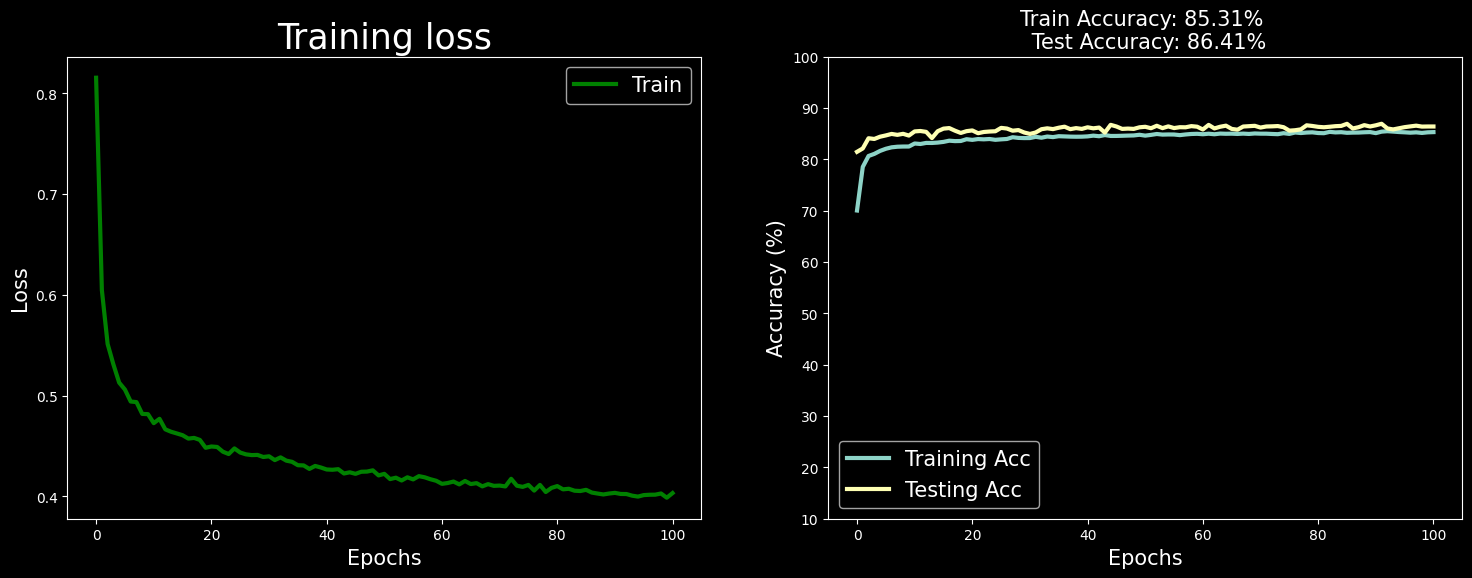

In [28]:
plot_fn(losses, trainAcc, testAcc)

## Model 4(with drop out & batch norm)

In [29]:
model4 = nn.Sequential(
          nn.Linear(4096,64),
          nn.ReLU(),
          nn.BatchNorm1d(64),
          nn.Dropout(0.3),
          nn.Linear(64,32),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.BatchNorm1d(32),
          nn.Linear(32,10),
          )
model4

Sequential(
  (0): Linear(in_features=4096, out_features=64, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=32, out_features=10, bias=True)
)

In [31]:
losses, trainAcc, testAcc = training_and_testing(model4)

 epochs : 0  loss :  0.70
 epochs : 10  loss :  0.56
 epochs : 20  loss :  0.39
 epochs : 30  loss :  0.41
 epochs : 40  loss :  0.50
 epochs : 50  loss :  0.50
 epochs : 60  loss :  0.35
 epochs : 70  loss :  0.36
 epochs : 80  loss :  0.34
 epochs : 90  loss :  0.44
 epochs : 100  loss :  0.51


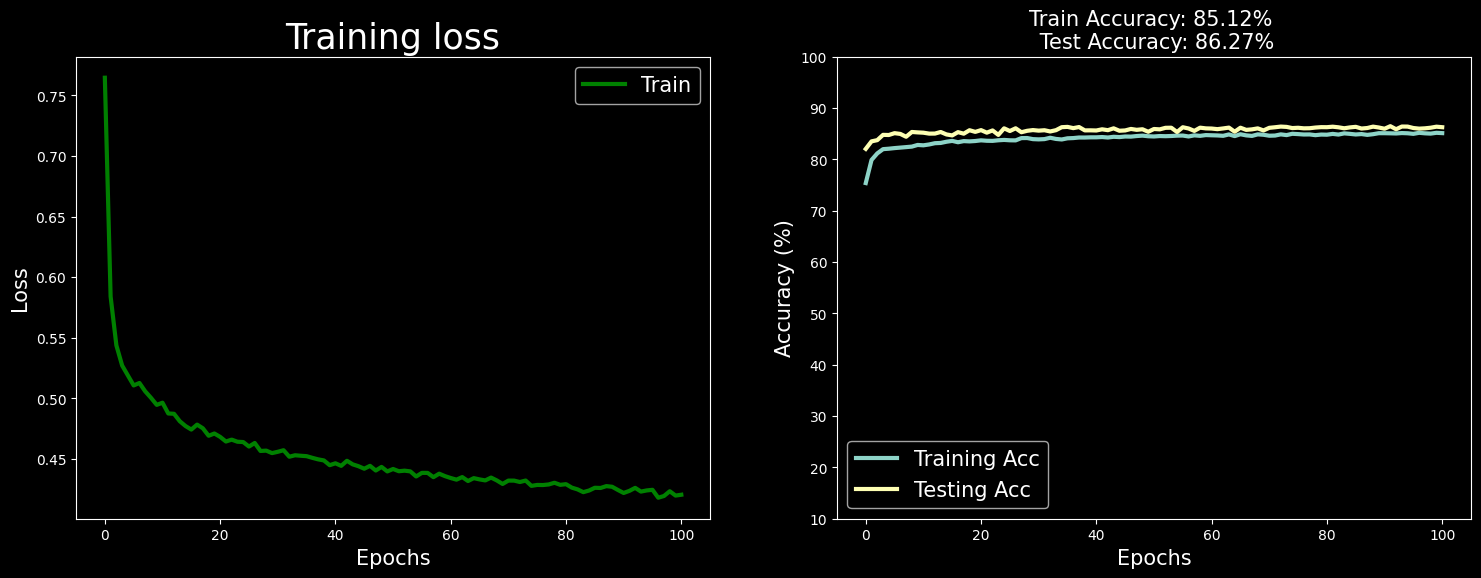

In [32]:
plot_fn(losses, trainAcc, testAcc)